In [95]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [96]:
# from google.colab import drive
# drive.mount("/content/drive")

In [97]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split


train_ratio = 0.8

In [4]:
!nvidia-smi

Sat May 14 12:25:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   25C    P8     1W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [5]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal
# !kill -9 2099692

In [6]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 25
print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)

np.random.seed(SEED_VALUE)

25


In [7]:
!ls
data_zip_file = './local1_folder.zip'
# data_zip_file2 = './local2_folder.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

archive.zip
Attetion-Multimodal-Bin2.ipynb
Attetion-Multimodal-Bin2-Moredata-Copy1.ipynb
Attetion-Multimodal-Bin2-Moredata.ipynb
Attetion-Multimodal-Bin.ipynb
Attetion-Multimodal-Copy1.ipynb
Attetion-Multimodal-copy2.ipynb
Attetion-Multimodal.ipynb
Attetion-Multimodal-LateFusion-Copy1.ipynb
Attetion-Multimodal-LateFusion.ipynb
Attetion-Multimodal-seed7.ipynb
Attetion-Multimodal-Soccer.ipynb
CNN.ipynb
Inception-Attetion-Copy1.ipynb
Inception-Attetion-Copy2.ipynb
Inception-Attetion.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
mountains.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_attention_f1_latefusion.pth.tar
my_checkpoint_attention_latefusion.pth.tar
my_checkpoint_attention.pth.tar
my_checkpoint_attention_seed_25_1e-3_drop02.pth.tar
my_checkpoint_attention_seed_25_f1_1e-3_drop02.pth.tar
my_checkpoint_attention_seed_84_1e-3.pth.tar
my_checkpoint_attention_seed_84_f1_1e-3.pth.tar
my_checkpoint_incept_atte

# Data preprocessing

## Image data

In [8]:
data_zip = zipfile.ZipFile(data_zip_file)
# data_zip2 = zipfile.ZipFile(data_zip_file2)

In [9]:
# [data_zip.writestr(t[0], t[1].read()) for t in ((n, data_zip2.open(n)) for n in data_zip2.namelist())]

In [10]:
len(data_zip.namelist())

58766

local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x734 at 0x7FAAE9AA73A0>
(734, 800, 3)


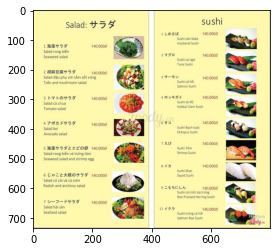

In [11]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [12]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [13]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)


data_df1[['Comment', 'Rating']].head()

Comment  Rating
0  Đặt dồi sụn của quán vì đọc comment thấy hấp d...     5.8
1  Dồi khá ngon, mua về còn nóng mở ra thơm phức,...     9.0
2  Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...     9.4
3  Không hiểu sao quán này được 7.9 luôn. Đặt bán...     4.6
4  Dồi sụn bé tẹo, giá quá cao so với các quán kh...     1.0

In [14]:
data_df = pd.concat([data_df1, data_df2, data_df3, data_df4, data_df5], ignore_index = True)

In [15]:
data_df.shape

(14174, 11)

In [16]:
data_df.isnull().sum()

RevId                   0
UserId                  0
ResId                   0
Comment                 3
image_urls              0
Food_score_cmt          2
Services_score_cmt      2
Atmosphere_score_cmt    2
Position_score_cmt      2
Price_score_cmt         2
Rating                  0
dtype: int64

In [17]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [18]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

RevId    UserId   ResId  \
0  3648046   8920424  965165   
1  3695359  18558601  965165   
2  3695487  13885433  965165   
3  4256913  11400976  965165   
4  4246644    525112  965165   

                                             Comment  \
0  Đặt dồi sụn của quán vì đọc comment thấy hấp d...   
1  Dồi khá ngon, mua về còn nóng mở ra thơm phức,...   
2  Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...   
3  Không hiểu sao quán này được 7.9 luôn. Đặt bán...   
4  Dồi sụn bé tẹo, giá quá cao so với các quán kh...   

                                          image_urls  Food_score_cmt  \
0  https://images.foody.vn/res/g97/965165/s800/fo...             5.0   
1  https://images.foody.vn/res/g97/965165/s800/fo...            10.0   
2  https://images.foody.vn/res/g97/965165/s800/fo...            10.0   
3  https://images.foody.vn/res/g97/965165/s800/fo...             1.0   
4  https://images.foody.vn/res/g97/965165/s800/fo...             1.0   

   Services_score_cmt  Atmosphere_score_cmt  Position_score_cmt  \
0                 9.0                   5.0                 5.0   
1                10.0                   9.0                 8.0   
2                10.0                   9.0                 8.0   
3                 5.0                   5.0                 6.0   
4                 1.0                   1.0                 1.0   

   Price_score_cmt  score  
0              5.0    5.8  
1              8.0    9.0  
2             10.0    9.4  
3              6.0    4.6  
4              1.0    1.0

In [19]:
data_df['image_urls'][0]

'https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-389-637116772226077520.jpg,https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-427-637116772199356351.jpg'

In [20]:
data_df.shape

(14170, 11)

In [21]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 7.8) & (data_df['score'] <= 7.8)][['Comment','score']].sort_values(by=['score'])

Comment  score
5      Đêm hôm đăng bài lại cồn cào 😭😭😭😭\nMình thực s...    7.8
10297  Quán chủ bán tầm trưa thôi mà 3 năm nay mình b...    7.8
10292  Xem review thèm quá nên lội lên Phan Bội Châu ...    7.8
10215  Thích ăn bánh tráng cuốn hơn là bánh tráng trộ...    7.8
10199  Mình gọi 1 bát bánh đa đầy đủ không mực 1 bát ...    7.8
...                                                  ...    ...
5301   • Quán có không gian xinh xắn, nhiều góc sống ...    7.8
5304   Vừa mới tức thì mình đặt đồ tại Highlands Coff...    7.8
5306   Đồ uống của Highland thì thôi không cần bàn rồ...    7.8
5110   Mình biết đến quán qua bài post về cafe thân t...    7.8
14112  Dịch dã ở nhà thèm pizza lên tìm thì thấy quán...    7.8

[570 rows x 2 columns]

In [22]:
# data_df['Comment'][5304]

In [23]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

In [24]:
data_df = data_df[data_df['label'] != 2]

1    6953
0    3023
Name: label, dtype: int64


<AxesSubplot:>

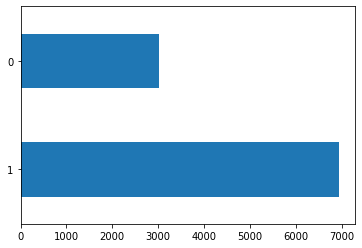

In [25]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [94]:
data_df[['Comment', 'score']].head()

Comment  score
0  Đặt dồi sụn của quán vì đọc comment thấy hấp d...    5.8
1  Dồi khá ngon, mua về còn nóng mở ra thơm phức,...    9.0
2  Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...    9.4
3  Không hiểu sao quán này được 7.9 luôn. Đặt bán...    4.6
4  Dồi sụn bé tẹo, giá quá cao so với các quán kh...    1.0

In [27]:
# def preprocess_imgpath(df):
#   new_df = df.assign(image_urls = data_df.image_urls.str.split(',')).explode('image_urls', ignore_index= True)
#   new_df['image_urls'] = new_df.apply(lambda x: '/'+x['image_urls'].split('/')[-1], axis = 1)
#   return new_df
# data_df = preprocess_imgpath(data_df)
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df


RevId    UserId   ResId  \
0      3648046   8920424  965165   
1      3695359  18558601  965165   
2      3695487  13885433  965165   
3      4256913  11400976  965165   
4      4246644    525112  965165   
...        ...       ...     ...   
14163  3430737  15366197  165697   
14164  2843371  11115693   19123   
14165  5807655    750185  249324   
14166  2853162   1865190   19123   
14167  6842833  10011937   19123   

                                                 Comment  \
0      Đặt dồi sụn của quán vì đọc comment thấy hấp d...   
1      Dồi khá ngon, mua về còn nóng mở ra thơm phức,...   
2      Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...   
3      Không hiểu sao quán này được 7.9 luôn. Đặt bán...   
4      Dồi sụn bé tẹo, giá quá cao so với các quán kh...   
...                                                  ...   
14163  Mình gọi 3p ăn no, thịt nướng rất nhìu, nem cũ...   
14164  Quán này giờ chia làm 2 quán\n1 quán đối diện ...   
14165  Sở trường của mình là món bún chả nên khi bạn ...   
14166  Từ hồi sinh viên năm 2 tức là 7 năm trước được...   
14167  Mình order hai suất về mà ăn không để ý là có ...   

                                              image_urls  score  label  
0      https://images.foody.vn/res/g97/965165/s800/fo...    5.8      0  
1      https://images.foody.vn/res/g97/965165/s800/fo...    9.0      1  
2      https://images.foody.vn/res/g97/965165/s800/fo...    9.4      1  
3      https://images.foody.vn/res/g97/965165/s800/fo...    4.6      0  
4      https://images.foody.vn/res/g97/965165/s800/fo...    1.0      0  
...                                                  ...    ...    ...  
14163  https://images.foody.vn/res/g17/165697/s800/fo...    8.4      1  
14164  https://images.foody.vn/res/g2/19123/s800/food...    2.6      0  
14165  https://images.foody.vn/res/g25/249324/s800/fo...   10.0      1  
14166  https://images.foody.vn/res/g2/19123/s800/food...    9.4      1  
14167  https://images.foody.vn/res/g2/19123/s800/food...    4.2      0  

[9976 rows x 7 columns]

In [28]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [29]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [30]:
data_df.shape

(9976, 7)

In [31]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

In [32]:
def preprocess_imgpath(df):
  new_df = df.assign(image_urls = data_df.image_urls.str.split(',')).explode('image_urls', ignore_index= True)
  return new_df
data_df_weight = preprocess_imgpath(data_df)

In [33]:
data_df_weight.shape

(20611, 7)

1    15454
0     5157
Name: label, dtype: int64


<AxesSubplot:>

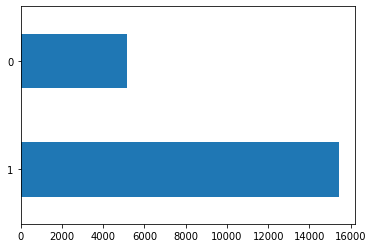

In [34]:
print(data_df_weight['label'].value_counts())
data_df_weight['label'].value_counts().plot(kind='barh')

In [35]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [36]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [37]:
data_df.head()

RevId    UserId   ResId  \
0  3648046   8920424  965165   
1  3695359  18558601  965165   
2  3695487  13885433  965165   
3  4256913  11400976  965165   
4  4246644    525112  965165   

                                             Comment  \
0  Đặt dồi sụn của quán vì đọc comment thấy hấp d...   
1  Dồi khá ngon, mua về còn nóng mở ra thơm phức,...   
2  Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...   
3  Không hiểu sao quán này được 7.9 luôn. Đặt bán...   
4  Dồi sụn bé tẹo, giá quá cao so với các quán kh...   

                                          image_urls  score  label  \
0  local1_folder-1/foody-doi-sun-pate-shop-online...    5.8      0   
1  local1_folder-1/foody-doi-sun-pate-shop-online...    9.0      1   
2  local1_folder-1/foody-doi-sun-pate-shop-online...    9.4      1   
3  local1_folder-1/foody-doi-sun-pate-shop-online...    4.6      0   
4  local1_folder-1/foody-doi-sun-pate-shop-online...    1.0      0   

                                  preprocess_comment  
0  đặt dồi sụn của quán vì đọc comment thấy hấp_d...  
1  dồi khá ngon mua về còn nóng mở ra thơm_phức s...  
2  đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...  
3  không hiểu sao quán này được 7 9 luôn đặt bánh...  
4  dồi sụn bé tẹo giá quá cao so với các quán khá...

In [38]:
len(data_df)

9975

In [39]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    vị_trí ở mặt đường nhưng ở cạnh quán mì cay to...
4188    thật tuyệt_cú mèo luôn mỗi cốc hoa_quả dầm ở đ...
4189    mình đã ăn_ở địa_điểm 211 chùa láng được hơn 1...
4190    nghe mọi người khen quán này dữ lém nên hôm_na...
Name: preprocess_comment, dtype: object

In [40]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

314     1
415     1
744     1
1011    1
1077    1
1543    1
1779    1
1808    1
1888    1
2302    1
2337    1
2528    1
2836    1
2873    1
2976    1
3489    1
3643    1
4328    1
4409    1
4645    1
5242    1
5564    1
5976    1
6341    1
6487    1
6748    1
7554    1
7603    1
8684    1
8881    1
9377    1
9523    1
Name: preprocess_comment, dtype: int64

# Load BPE, Vocab of PhoBERT and DataGen

In [41]:
# a = []
# for i in range(3):
#   a.append(torch.Tensor([1,2,3]))
# a
# b = torch.stack(a)
# b.shape

In [42]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [43]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  custom_labels = []
  for bt in batch:
    for i in range(len(bt[1])):
      input_ids.append(bt[0]['input_ids'][0])
      attention_masks.append(bt[0]['attention_mask'][0])
    # print(bt[1])
    imgs.extend(bt[1])
    img_len.append(len(bt[1]))
    labels.append(bt[2])
    custom_labels.extend([bt[2]] * len(bt[1]))
  bert_tokens = torch.stack(input_ids)
  attention_masks = torch.stack(attention_masks)
  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)
  custom_labels = torch.LongTensor(custom_labels)

  return  { 'input_ids': bert_tokens , 'attention_mask':attention_masks} , imgs_torch, img_len, labels, custom_labels

In [44]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index()
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    text = self.df["preprocess_comment"][idx]
    text = tokenizer(text, padding='max_length', truncation=True, max_length = MAX_LEN, return_tensors="pt")

    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
      img = Image.open(data_zip.open(path))
      if self.transform is not None:
        img = self.transform(img)
      img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return (text, img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 8, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([299, 299]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(),
          T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [45]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0]['input_ids'])
    print(bat[1].shape)
    print(sum(bat[2]))
    print(len(bat[3]))
    print(bat[4])

1    6952
0    3023
Name: label, dtype: int64
1    5562
0    2418
Name: label, dtype: int64
1    695
0    303
Name: label, dtype: int64
1    695
0    302
Name: label, dtype: int64
0
tensor([[   0,  667,  108,  ...,    1,    1,    1],
        [   0, 1152, 9756,  ...,    1,    1,    1],
        [   0,   39,  857,  ...,    1,    1,    1],
        ...,
        [   0,   68, 4275,  ...,    1,    1,    1],
        [   0,  133, 2288,  ...,    1,    1,    1],
        [   0,  569, 8263,  ...,    1,    1,    1]])
torch.Size([15, 3, 299, 299])
15
8
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1])


In [46]:
# batch_dat = next(iter(dm.train_dataloader()))[0]
# dat = tokenize_data(batch_dat,vocab_path, bpe_path)
# print(dat)

# PhoBERT

In [47]:
from transformers import RobertaModel, RobertaConfig, AdamW
from transformers import RobertaForSequenceClassification

pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"
# config = RobertaConfig.from_pretrained(
#     pretrained_config_path, from_tf=False, output_hidden_states=False,
# )

# PhoBERT = RobertaModel.from_pretrained(
#     pretrained_model_path,
#     config=config
# )

In [48]:
# PhoBERT

In [49]:
class Bert_Lstm(nn.Module):
  def __init__(self):
    super(Bert_Lstm, self).__init__()
    self.config = RobertaConfig.from_pretrained(
    'vinai/phobert-base', from_tf=False, output_hidden_states=False)

    self.PhoBERT = RobertaModel.from_pretrained(
    'vinai/phobert-base',
    config=self.config )

    self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
  def forward(self, texts):
    bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
    bert_out = bert_out['last_hidden_state']
    out, _ = self.lstm(bert_out)
    feature_extract = out[:,-1,:].contiguous()

    return feature_extract


In [50]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [51]:
from torchvision.models import inception_v3

In [52]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

In [53]:
# model = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)

In [54]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
    self.flat = nn.Linear(2048, 128)

  def forward(self, image):
    feature = self.incept_sequen(image)
    # print(feature.shape)
    out = self.avgpool(feature)
    # print(out.shape)
    out = self.drop(out)
    out = out.contiguous().view(-1, 2048)
    # out = 
    img_fea = self.flat(out)

    return img_fea


In [55]:
# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
        
#     def forward(self, x):
#         return x
# model.fc = Identity()
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output
#     return hook

# model.Mixed_7b.register_forward_hook(get_activation('Mixed_7b'))

In [56]:
# a = torch.rand(16,3,299,299)
# a[0].shape

In [57]:
# mod = Inception()
# mod

In [58]:
# out = mod(a)
# print(out.shape)

In [59]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)), pooling='avg')
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [60]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [61]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [62]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [63]:
class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [64]:
# from sklearn.utils.class_weight import compute_class_weight

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Computation device: {device}\n")

# class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(data_df_weight['label']), y=data_df_weight['label'])
# class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)


In [65]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(data_df_weight['label']), y=data_df_weight['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)


Computation device: cuda



In [66]:

class Concatmodal(nn.Module):
  def __init__(self):
    super(Concatmodal,self).__init__()
    # self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
#     self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,2)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
  
  def forward(self, image, inputs, labels=None):
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    image = image.to(device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
#     cat = self.dense(cat)
    out = self.cl(cat)

    return out

# def train(model):
#   loss_func = nn.CrossEntropyLoss()
#   optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
#   # optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#   lr_scheduler = LRScheduler(optimizer)
#   early_stopping = EarlyStopping()

#   model.to(device)

#   for epoch in range(3):
#     running_loss = 0.0
#     reporting_step = 60
#     model.train()

#     for i, (texts, images, labels) in enumerate(dm.train_dataloader()):
#       labels = labels.to(device)
#       optimizer.zero_grad()

#       outputs = model(images, texts)
#       loss = loss_func(outputs, labels)

#       loss.backward()
#       optimizer.step()

#       running_loss += loss.item()
#       if i % reporting_step == reporting_step-1:
#             print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
#             running_loss = 0.0

    # with torch.no_grad:
    #   for i, (texts, images, labels) in enumerate(dm.train_dataloader()):
    #     labels = labels.to(device)

    #     model.eval()
    #     outputs = model(images, texts)

    #     loss = loss_func(outputs, labels)


In [67]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100

  counter = 0
  # total = 0

  model.train()
  soft_m = nn.Softmax(dim=-1)
  train_preds = np.array([])
  train_labels = np.array([])

  for i, (texts, images, len_img_list, labels, custom_labels) in enumerate(dm.train_dataloader()):
      counter += 1
      custom_labels = custom_labels.to(device)
      optimizer.zero_grad()

      outputs = model(images, texts)

      loss = criterion(outputs, custom_labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      predictions = predictions.cpu().numpy()
      custom_labels = custom_labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, custom_labels), axis=0)
      # _, preds = torch.max(outputs.data, 1)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_ac = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']

  return train_loss, train_ac

In [68]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (texts, images, len_img_list, labels, custom_labels) in enumerate(dm.val_dataloader()):
        counter += 1
        custom_labels = custom_labels.to(device)

        outputs = model(images, texts)

        loss = criterion(outputs, custom_labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        predictions = predictions.cpu().numpy()
        custom_labels = custom_labels.cpu().numpy()

        val_running_loss += loss.item()
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, custom_labels), axis=0)
    
  # val_preds = val_preds.cpu().numpy()
  # val_labels = val_labels.cpu().numpy()

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
  # val_ac = accuracy_score(val_labels, val_preds)
  val_ac = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']

  return val_loss, val_ac


In [69]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

def voting(predictions, aspect_sample, output_scores):
    voting_predictions = np.array([])
    total_term = len(aspect_sample)
    ot_scores = np.zeros((total_term, 2))
    total_token = 0
    total_term = 0
    start_token = 0

    for i in range(len(aspect_sample)):
        sentiment = [0] * 2
        for j in range(aspect_sample[i]):
            numtoken = aspect_sample[i]
            ot_scores[i] = np.sum(output_scores[start_token:start_token+numtoken], axis=0)
            idx = j + total_token
            sentiment[predictions[idx]] += 1
        voting_count = np.where(sentiment == np.amax(sentiment))
        if len(voting_count[0]) > 1:
            voting_predictions = np.append(voting_predictions,np.argmax(ot_scores[i]))
        else:
            voting_predictions = np.append(voting_predictions,np.argmax(sentiment))
            
        start_token = start_token+numtoken
        total_token += numtoken
            
#     print(voting_predictions.shape)
    return voting_predictions

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = np.array([])
  test_labels = np.array([])
#   test_preds = torch.tensor([], device=device)
#   test_labels = torch.tensor([], device = device)
  

  soft_m = nn.Softmax(dim=-1)


  with torch.no_grad():
    for i, (texts, images, len_img_list, labels, custom_labels) in enumerate(dm.test_dataloader()):
        counter += 1
        custom_labels = custom_labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        
        predictions = predictions.cpu().numpy()
        output_scores = output_scores.cpu().numpy()
        
        voting_predictions = voting(predictions, len_img_list, output_scores)
        
        test_preds = np.concatenate((test_preds, voting_predictions), axis=0)
        test_labels = np.concatenate((test_labels, labels), axis=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
       
  print('test',classification_report(test_labels, test_preds))
  print('test_ac',accuracy_score(test_labels, test_preds))
  print('Confusion', confusion_matrix(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])
 
  # test_loss = test_running_loss / counter



In [70]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [71]:
# testing(mo, dm)

In [84]:
def save_checkpoint(state, filename='my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_drop.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [73]:
# def save_checkpoint1(state, filename='my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_f1_nodrop.pth.tar'):
#     print('Saving....'+ filename)
#     torch.save(state, filename)

In [74]:
%ls

archive.zip
Attetion-Multimodal-Bin2.ipynb
Attetion-Multimodal-Bin2-Moredata-Copy1.ipynb
Attetion-Multimodal-Bin2-Moredata.ipynb
Attetion-Multimodal-Bin.ipynb
Attetion-Multimodal-Copy1.ipynb
Attetion-Multimodal-copy2.ipynb
Attetion-Multimodal.ipynb
Attetion-Multimodal-LateFusion-Copy1.ipynb
Attetion-Multimodal-LateFusion.ipynb
Attetion-Multimodal-seed7.ipynb
Attetion-Multimodal-Soccer.ipynb
CNN.ipynb
Inception-Attetion-Copy1.ipynb
Inception-Attetion-Copy2.ipynb
Inception-Attetion.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
mountains.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_attention_f1_latefusion.pth.tar
my_checkpoint_attention_latefusion.pth.tar
my_checkpoint_attention.pth.tar
my_checkpoint_attention_seed_25_1e-3_drop02.pth.tar
my_checkpoint_attention_seed_25_f1_1e-3_drop02.pth.tar
my_checkpoint_attention_seed_84_1e-3.pth.tar
my_checkpoint_attention_seed_84_f1_1e-3.pth.tar
my_checkpoint_incept_atte

In [75]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [76]:
def freeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = False
  for param in model.incept.incept.parameters():
    param.requires_grad = False
  for param in model.incept.incept_sequen.parameters():
    param.requires_grad = False
    # print(param)
  return model
def unfreeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = True
  for param in model.incept.incept.parameters():
    param.requires_grad = True
    # print(param)
  return model
# model = freeze(model)

In [81]:
model = Concatmodal()
model = freeze(model)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [82]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

159,555,402 total parameters.
722,562 training parameters.


In [79]:
# model

In [80]:
for name, child in model.incept.incept_sequen.named_children():
#     print(name)
    if name in ['17']:
        print(name + ' has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

17 has been unfrozen.


In [101]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

159,621,194 total parameters.
6,865,154 training parameters.


In [85]:
from torch.optim import lr_scheduler


train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]

#define model
# model = Concatmodal()
# model = freeze(model)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# # define hyper
# optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss(weight=class_weights)
#training
epochs = 20
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()

min_loss = np.Inf
max_f1 = 0
for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_epoch_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f"Train acc: {train_epoch_ac:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

    
  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_epoch_ac)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_epoch_ac)
  epoch_list.append(epoch)

  if (min_loss >= val_epoch_loss):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss': val_epoch_loss}
      print('Better ver saved')
      min_loss = val_epoch_loss
      # filename = 'model{loss}-{epoch}.pth.tar'
      # filename = filename.format(loss= min_loss, epoch= epoch)
      save_checkpoint(checkpoint)
    
#   if (val_epoch_ac >= max_f1):
#       checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss': val_epoch_loss}
#       print('Better ver saved')
#       max_f1 = val_epoch_ac
#       # filename = 'model{loss}-{epoch}.pth.tar'
#       # filename = filename.format(loss= min_loss, epoch= epoch)
#       save_checkpoint1(checkpoint)

testing(model, dm)


159,555,402 total parameters.
722,562 training parameters.
Epoch 0 of 20
Epoch 0 Step 99 ave_loss 0.6798
Epoch 0 Step 199 ave_loss 0.4783
Epoch 0 Step 299 ave_loss 0.3984
Epoch 0 Step 399 ave_loss 0.3726
Epoch 0 Step 499 ave_loss 0.4355
Epoch 0 Step 599 ave_loss 0.4634
Epoch 0 Step 699 ave_loss 0.3813
Epoch 0 Step 799 ave_loss 0.4146
Epoch 0 Step 899 ave_loss 0.3456
[[ 2983  1121]
 [ 1662 10725]]
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83       517
         1.0       0.94      0.95      0.94      1523

    accuracy                           0.91      2040
   macro avg       0.89      0.88      0.89      2040
weighted avg       0.91      0.91      0.91      2040

[[ 421   96]
 [  79 1444]]
Train Loss: 0.4288
Train acc: 0.7835
Val Loss: 0.2916
Val Acc: 0.8854
Better ver saved
Saving....my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_drop.pth.tar
Epoch 1 of 20
Epoch 1 Step 99 ave_loss 0.3491
Epoch 1 Step 199 ave_loss 0

In [86]:
def show_graph(train_accu, eval_accu, epoch_list, type='F1'):
    plt.plot(epoch_list,train_accu ,'-o')
    plt.plot(epoch_list,eval_accu,'-o')
    plt.xlabel('epoch')
    plt.ylabel(type)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid '+type)

    plt.show()

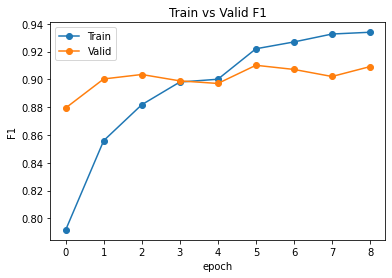

In [83]:
# freeze inception 0
show_graph(train_f1_list, val_f1_list, epoch_list)

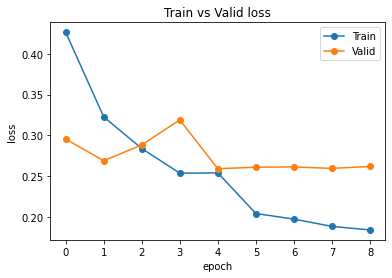

In [84]:
# freeze inception 0
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

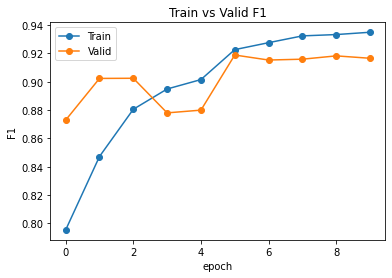

In [81]:
# freeze inception 25
show_graph(train_f1_list, val_f1_list, epoch_list)

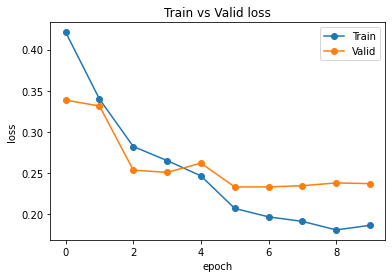

In [82]:
# freeze inception 25
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

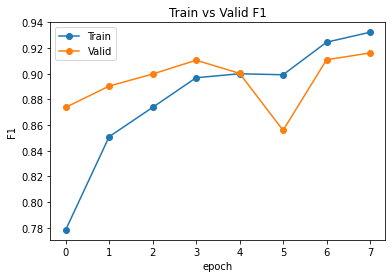

In [83]:
# freeze inception 84
show_graph(train_f1_list, val_f1_list, epoch_list)

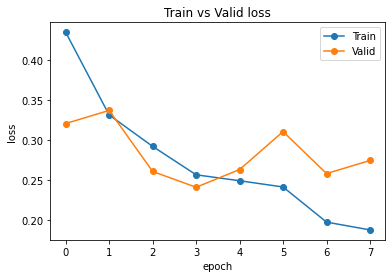

In [84]:
# freeze inception 84
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

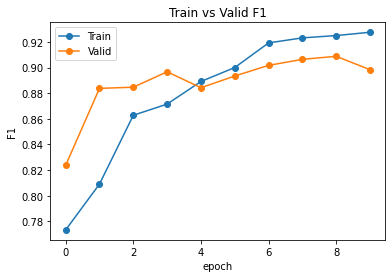

In [83]:
# freeze inception
show_graph(train_f1_list, val_f1_list, epoch_list)

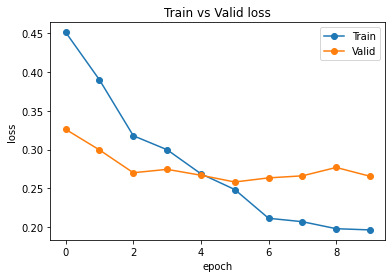

In [85]:
# freeze inception
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

In [77]:
from torch.optim import lr_scheduler

#define model
# model = Concatmodal()
# model = freeze(model)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# # define hyper
# optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss(weight=class_weights)
#training
epochs = 20
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()

min_loss = np.Inf
for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_epoch_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )
  lr_scheduler(val_epoch_ac)

  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f"Train acc: {train_epoch_ac:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')

  if (min_loss >= val_epoch_loss):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss': val_epoch_loss}
      print('Better ver saved')
      min_loss = val_epoch_loss
      # filename = 'model{loss}-{epoch}.pth.tar'
      # filename = filename.format(loss= min_loss, epoch= epoch)
      save_checkpoint(checkpoint)

testing(model, dm)


159,621,194 total parameters.
788,354 training parameters.
Epoch 0 of 20
Epoch 0 Step 99 ave_loss 0.6435
Epoch 0 Step 199 ave_loss 0.4543
Epoch 0 Step 299 ave_loss 0.4621
Epoch 0 Step 399 ave_loss 0.3651
Epoch 0 Step 499 ave_loss 0.4095
Epoch 0 Step 599 ave_loss 0.3921
Epoch 0 Step 699 ave_loss 0.4069
Epoch 0 Step 799 ave_loss 0.3953
Epoch 0 Step 899 ave_loss 0.3727
[[ 3046  1058]
 [ 1665 10722]]
              precision    recall  f1-score   support

         0.0       0.89      0.73      0.80       517
         1.0       0.91      0.97      0.94      1523

    accuracy                           0.91      2040
   macro avg       0.90      0.85      0.87      2040
weighted avg       0.91      0.91      0.90      2040

[[ 376  141]
 [  48 1475]]
Train Loss: 0.4227
Train acc: 0.7892
Val Loss: 0.3706
Val Acc: 0.8695
Better ver saved
Saving....my_checkpoint_multivoting_20_label01_freeze_adam.pth.tar
Epoch 1 of 20
Epoch 1 Step 99 ave_loss 0.3581
Epoch 1 Step 199 ave_loss 0.3636
Epoch 1 Step 

In [87]:
import gc
del model
gc.collect()

41

In [88]:
torch.cuda.empty_cache()

In [89]:
PATH = "./my_checkpoint_multivoting_20_label01_freeze_adam_normalize_img_drop.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
model = Concatmodal()
model.load_state_dict(checkpoint['state_dict'])

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [90]:
checkpoint['epoch']

3

In [121]:
model.to(device)
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       302
         1.0       0.96      0.95      0.95       695

    accuracy                           0.93       997
   macro avg       0.92      0.93      0.92       997
weighted avg       0.94      0.93      0.94       997

test_ac 0.9348044132397192
Confusion [[273  29]
 [ 36 659]]
Macro_f1 0.9233088721711973


In [92]:
model.to(device)
testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       302
         1.0       0.96      0.96      0.96       695

    accuracy                           0.94       997
   macro avg       0.93      0.93      0.93       997
weighted avg       0.94      0.94      0.94       997

test_ac 0.9398194583751254
Confusion [[272  30]
 [ 30 665]]
Macro_f1 0.9287483920148649


In [75]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=5e-4)
optimizer.load_state_dict(checkpoint['optimizer'])
model = freeze(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

159,621,451 total parameters.
788,611 training parameters.


727


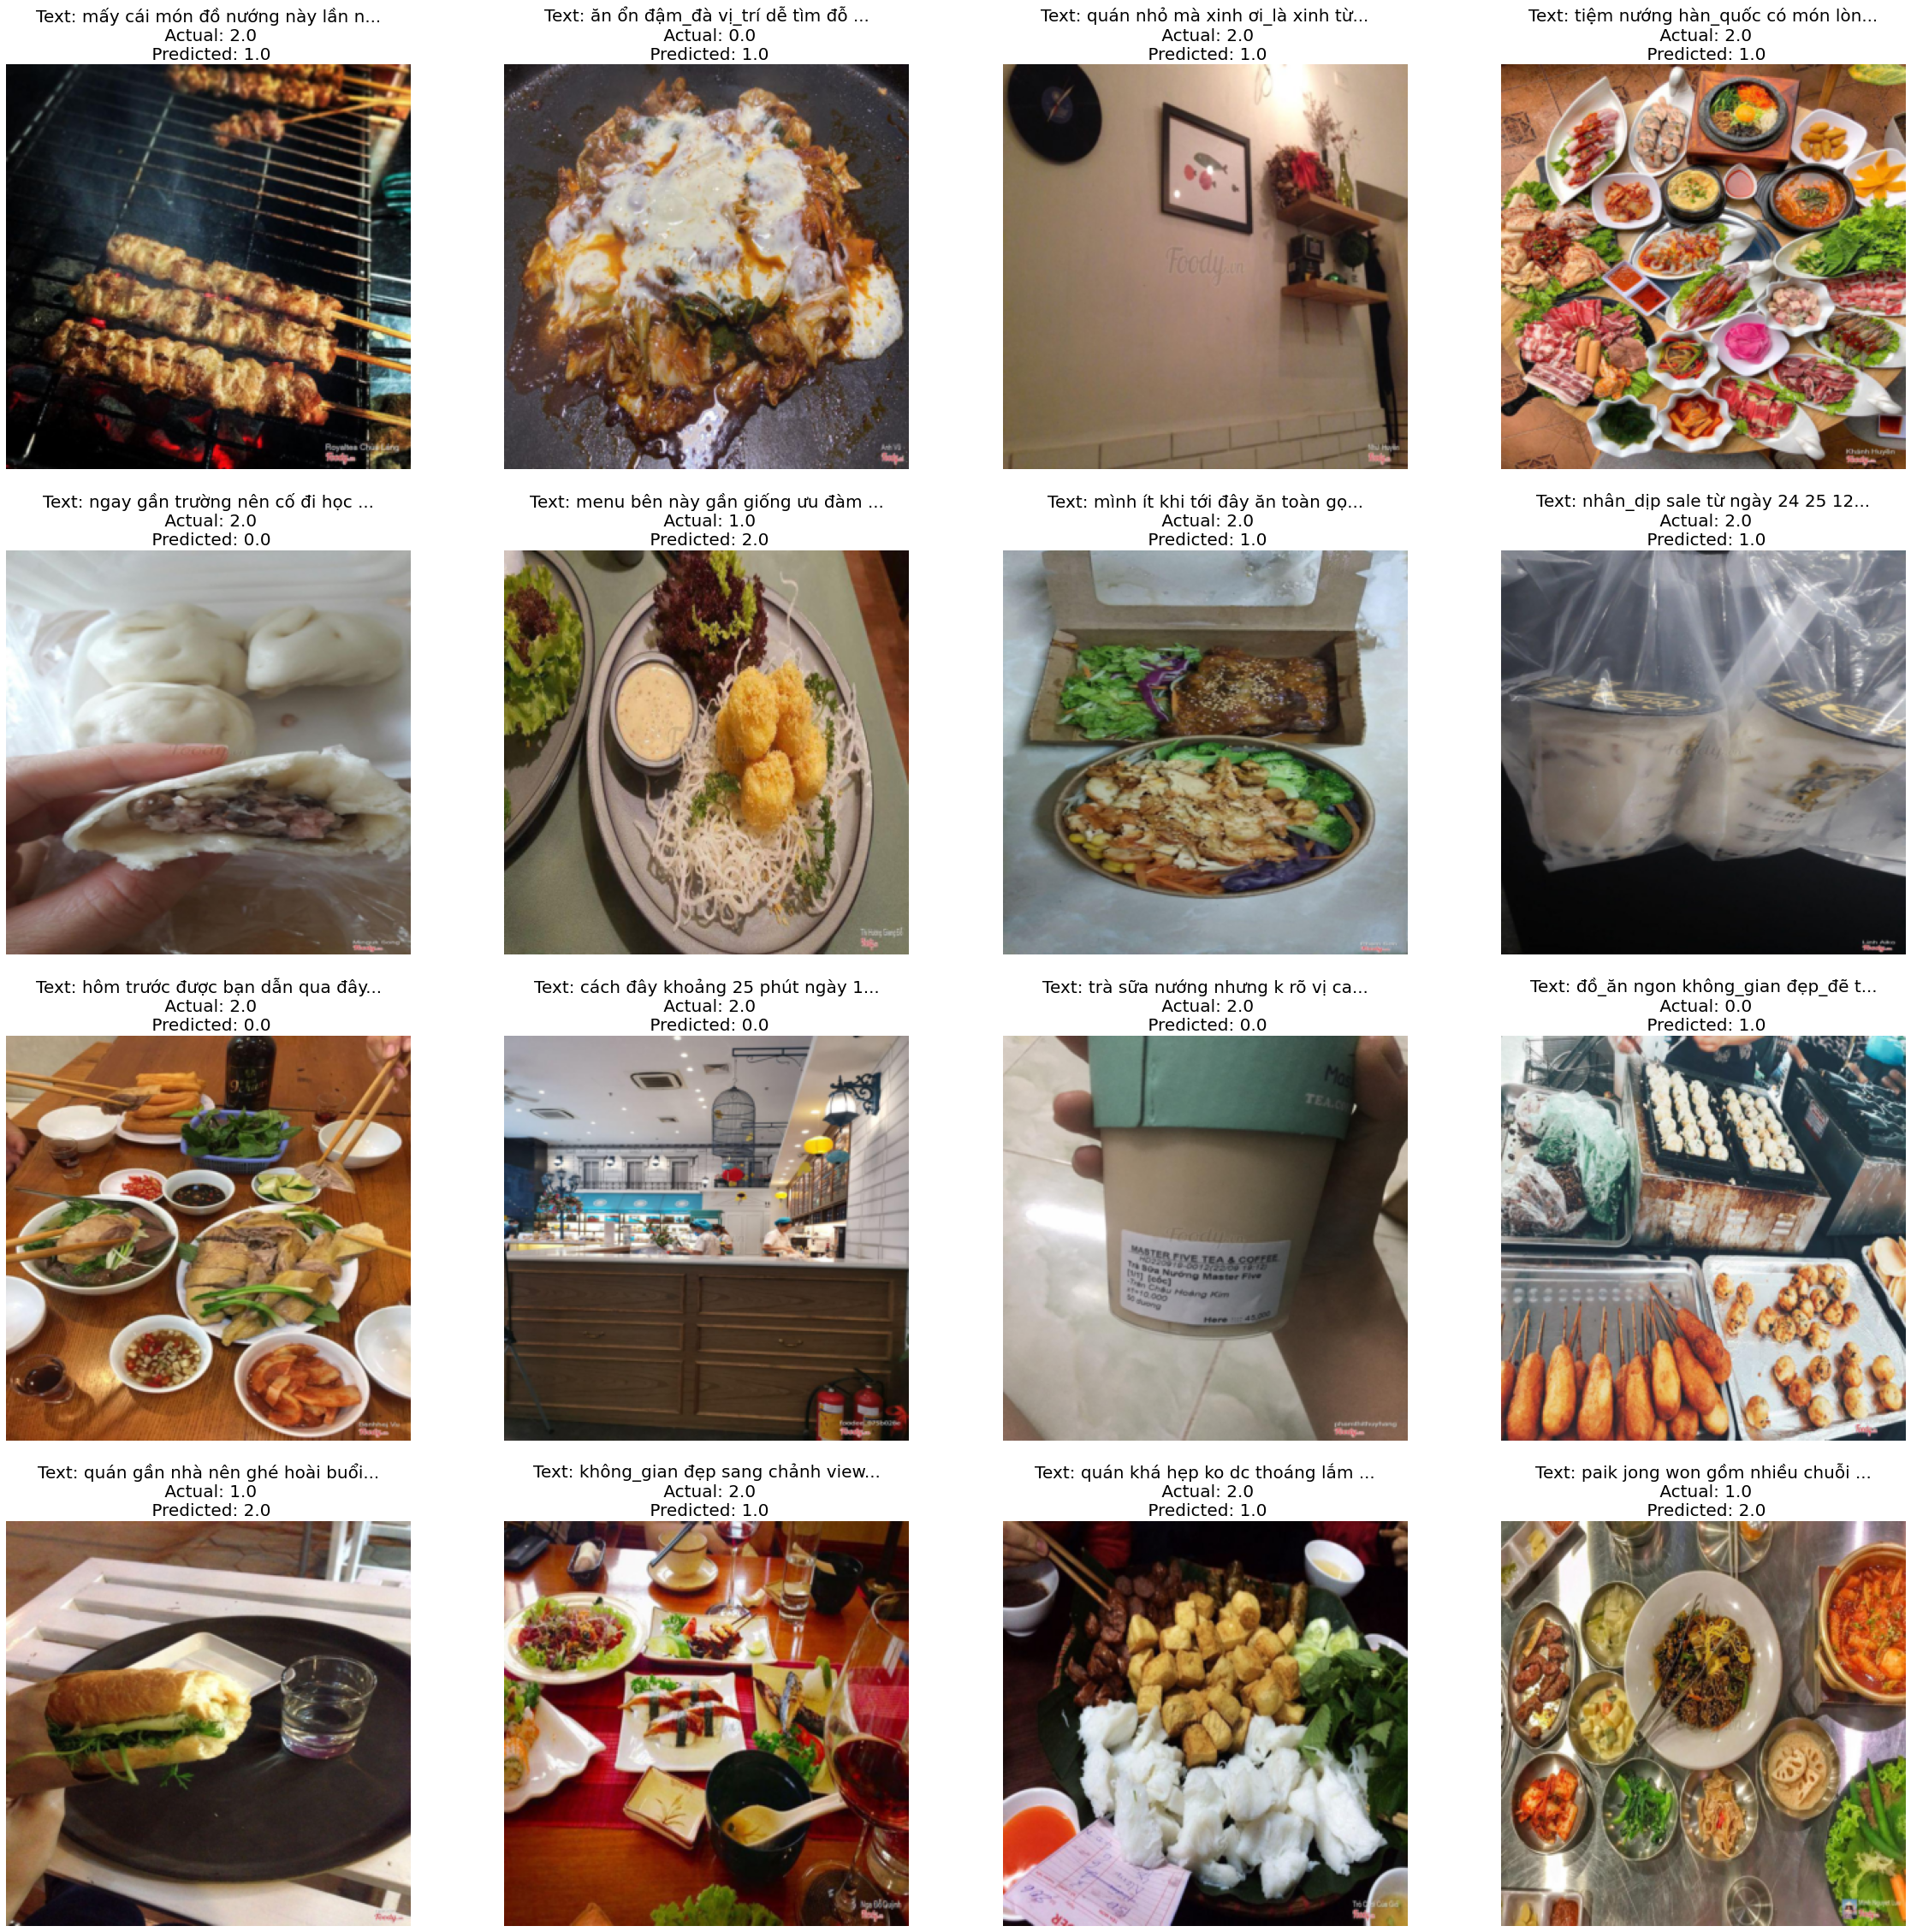

In [ ]:
import cv2
model.to(device)
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)

        outputs = model(images, texts)
        # print(outputs.device)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for i in images:
          test_img.append(i) 

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label != label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label), fontsize=20)
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_false_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


